# Марковский процесс принятия решений

#### дедлайн (жёсткий) задания: 3 апреля, 23:59 UTC+3

#### при сдаче задания нужно данный файл послать в систему сдачи

В данной работе рассматриваются методы, разработанные для решения Марковских процессов принятия решений, **M**arkov **D**ecision **P**rocesses, **MDP**. В самом широком смысле, MDP определяется тем, как он изменяет состояния и как вычисляются награды.

Переход состояний определяется распределением $P(s' |s,a)$ &mdash; насколько вероятно перейти в состояние $s'$, если производится действие $a$ в состоянии $s$. Существует несколько способов определить функцию вознаграждений, однако ради удобства будет использована следующая сигнатура: $r(s,a,s')$.

# Работу выполнил: Ахмаджонов Мумтозбек Козимжон Угли, М05-317.

Для начала, давайте определим простой MDP, изображённый на рисунке ниже:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

In [1]:
import typing as tp

In [2]:
transition_probs = {
    "s0": {"a0": {"s0": 0.5, "s2": 0.5}, "a1": {"s2": 1}},
    "s1": {"a0": {"s0": 0.7, "s1": 0.1, "s2": 0.2}, "a1": {"s1": 0.95, "s2": 0.05}},
    "s2": {"a0": {"s0": 0.4, "s2": 0.6}, "a1": {"s0": 0.3, "s1": 0.3, "s2": 0.4}},
}
rewards = {"s1": {"a0": {"s0": +5}}, "s2": {"a1": {"s0": -1}}}

from mdp import MDP

mdp = MDP(transition_probs, rewards, initial_state="s0")

Теперь можно использовать MDP как и другие среды от Open AI Gym:

In [3]:
print("initial state =", mdp.reset())
next_state, reward, done, info = mdp.step("a1")
print("next_state = %s, reward = %s, done = %s" % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


но также есть и другие методы, необходимые для имплементации алгоритма итерацонной оптимизации ценности (Value Iteration)

In [4]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions("s1"))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states("s1", "a0"))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward("s1", "a0", "s0"))
print(
    "mdp.get_transition_prob('s1', 'a0', 's0') = ",
    mdp.get_transition_prob("s1", "a0", "s0"),
)

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Опционально: визуализация MDP

Вы можете визуализировать MDP с помощью функции отрисовки, написанной [neer201](https://github.com/neer201).

Для этого требуется установить graphviz системно и для Python. На Unix-подобных системах (Ubuntu) для этого достатчно выполнить следующие команды:

1. `sudo apt-get install graphviz`
2. `pip install graphviz`
3. перезагрузить этот ноутбук

__Замечание:__ Установка graphviz на некоторые ОС (особенно Windows) может быть нетривиальной. Поэтому можно пропусить данный шаг и использовать стандартную визуализацию.

In [5]:
from mdp import has_graphviz
from IPython.display import display

print("Graphviz доступен:", has_graphviz)

Graphviz доступен: False


In [6]:
if has_graphviz:
    from mdp import (
        plot_graph,
        plot_graph_with_state_values,
        plot_graph_optimal_strategy_and_state_values,
    )

    display(plot_graph(mdp))

# Итерационная оптимизация ценности, Value Iteration (вплоть до 4 баллов)

Теперь построим первый способ решения MDP. Простейший на данный момент алгоритм называется итерационной оптимизацией ценности или __V__alue __I__teration

Ниже представлен псевдокод VI:

---

`1.` Инициализация $V^{(0)}(s)=0$, for all $s$

`2.` Для $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, для всех $s$

---

Для начала выпишем функцию вычисления $Q$-функции ценности $Q^{\pi}$, определив следующим образом

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [7]:
# %%writefile mdp_get_action_value.py
def get_action_value(
    mdp: MDP, state_values: tp.Dict[str, float], state: str, action: str, gamma: float
) -> float:
    """Вычисляет Q(s,a) согласно формуле выше"""
    Q = 0.0
    all_states = mdp.get_all_states()
    for s in all_states:
        P = mdp.get_transition_prob(state, action, s)
        r = mdp.get_reward(state, action, s)
        V = state_values[s]
        Q += P * (r + gamma * V)
    return Q

In [8]:
# from mdp_get_action_value import *

In [9]:
import numpy as np

test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, "s2", "a1", 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, "s1", "a0", 0.9), 3.95)

Используя $Q(s,a)$ можно определить "следующее" $V(s)$ для итерационной оптимизации ценности.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [10]:
def get_new_state_value(
    mdp: MDP, state_values: tp.Dict[str, float], state: str, gamma: float
) -> float:
    """Вычисляет следующее V(s) согласно формуле выше. Просьба не изменять state_values в процессе."""
    if mdp.is_terminal(state):
        return 0

    # Ваша имплементация ниже
    all_actions = mdp.get_possible_actions(state)
    Q_max = 0.0
    for a in all_actions:
        Q_curr = get_action_value(mdp, state_values, state, a, gamma)
        if Q_curr > Q_max:
            Q_max = Q_curr

    return Q_max

In [11]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, "s0", 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, "s2", 0.9), 1.08)
assert test_Vs == test_Vs_copy, "просьба не изменять state_values в get_new_state_value"

Наконец-то можно скомбинировать написанное в работающий алгоритм.

In [12]:
# %%time

# гиперпараметры
gamma = 0.9            # фактор дисконтирования MDP
num_iter = 100         # максимальное количество итераций, не включая инициализацию
# останов VI, если новые значения V(s) настолько близки к старым (или ближе)
min_difference = 0.001

# инициализация V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Вычисление новых V(s) используя определённые выше функции.
    # Должен быть словарь {state : float V_new(state)}
    new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in state_values}

    assert isinstance(new_state_values, dict)

    # Вычисление темпоральных различий V(s)
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("Итерация %4i   |   разность max_s|V_new(s) - V_old(s)|: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Останов")
        break

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.19277

In [13]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [14]:
print("Финальные ценности состояний:", state_values)

assert abs(state_values["s0"] - 3.781) < 0.01
assert abs(state_values["s1"] - 7.294) < 0.01
assert abs(state_values["s2"] - 4.202) < 0.01

Финальные ценности состояний: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Теперь используем полученные $V^{*}(s)$ для определения оптимальных действий в каждом состоянии

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
Единственное отличие по сравнению с вычислением `V(s)` состоит в извлечении не `max`, а `argmax`: поиск действия с максимальной ценностью `Q(s,a)`.

In [15]:
def get_optimal_action(
    mdp: MDP, state_values: tp.Dict[str, float], state: str, gamma: float = 0.9
) -> str:
    """Выбор оптимального действия, используя формулу выше."""
    if mdp.is_terminal(state):
        return None
    all_actions = mdp.get_possible_actions(state)
    a_max = all_actions[0]
    Q_max = 0.0
    for a in all_actions:
        Q_curr = get_action_value(mdp, state_values, state, a, gamma)
        if Q_curr > Q_max:
            Q_max = Q_curr
            a_max = a
    return a_max

In [16]:
assert get_optimal_action(mdp, state_values, "s0", gamma) == "a1"
assert get_optimal_action(mdp, state_values, "s1", gamma) == "a0"
assert get_optimal_action(mdp, state_values, "s2", gamma) == "a1"

In [17]:
if has_graphviz:
    try:
        display(plot_graph_optimal_strategy_and_state_values(mdp, state_values))
    except ImportError:
        raise ImportError(
            'Запустите ячейку, начинающуюся с "%%writefile mdp_get_action_value.py"'
        )

In [18]:
%%time

# Оценка средней награды агента

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("средняя награда: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

средняя награда:  0.4733
CPU times: user 517 ms, sys: 8.64 ms, total: 526 ms
Wall time: 521 ms


### Frozen lake

In [19]:
from mdp import FrozenLakeEnv

mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [20]:
def value_iteration(
    mdp: MDP,
    state_values: tp.Dict[str, float] = None,
    gamma: float = 0.9,
    num_iter: int = 1000,
    min_difference: float = 1e-5,
    verbose: bool = True,
) -> tp.Dict[str, float]:
    """Выполняет num_iter шагов итерационной оптимизации ценности, начиная с state_values.
    То же, что и ранее, но в формате функции"""
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Вычислить новые ценности состояний, используя определённые выше функции.
        # В результате должен получиться словарь формата {state : new_V(state)}
        new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in state_values}

        assert isinstance(new_state_values, dict)

        # Вычислить темпоральную разность по значениям ценности
        diff = max(
            abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states()
        )

        if verbose:
            print(
                "Итерация %4i   |   разность max_s|V_new(s) - V_old(s)|: %6.5f   |   V(start): %.3f "
                % (i, diff, new_state_values[mdp._initial_state])
            )

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [21]:
%%time

state_values = value_iteration(mdp)

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 
CPU times: user 9.93 ms, sys: 0 ns, total: 9.93 ms
Wall time: 9.78 ms


In [22]:
%%time

s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*

CPU times: user 2.03 ms, sys: 16 µs, total: 2.04 ms
Wall time: 1.96 ms


### Время визуализаций!

Обычно полезно и интересно видеть, что в действительности Ваш алгоритм выучивает под капотом. Для этого можно изобразить V-функцию и оптимальные действия на каждом шаге алгоритма VI.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

после итерации 0
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 


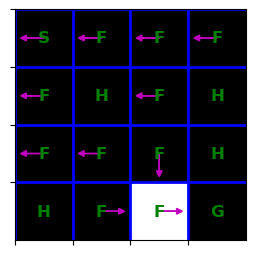

после итерации 1
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 


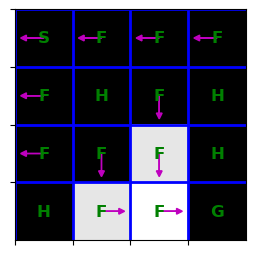

после итерации 2
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 


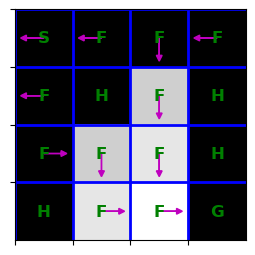

после итерации 3
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 


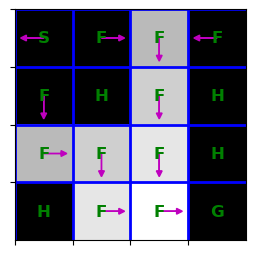

после итерации 4
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 


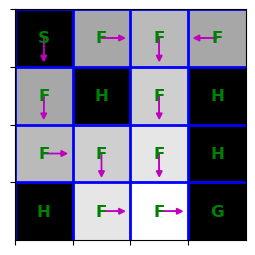

после итерации 5
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 


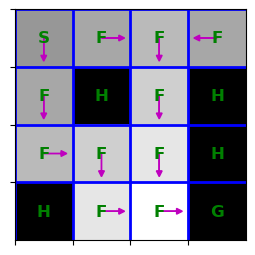

после итерации 6
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


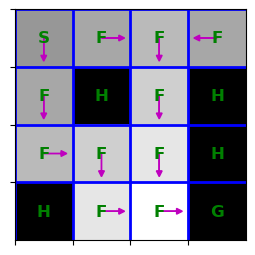

после итерации 7
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


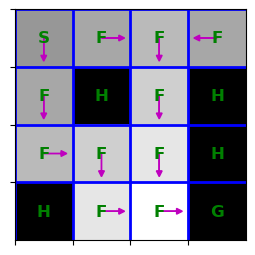

после итерации 8
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


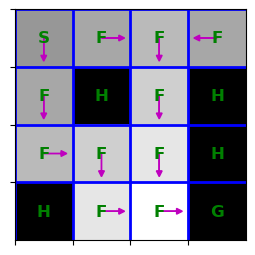

после итерации 9
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


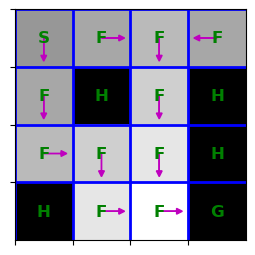

CPU times: user 1.27 s, sys: 83.7 ms, total: 1.36 s
Wall time: 1.33 s


In [24]:
%%time

state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

после итерации 29
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.198 


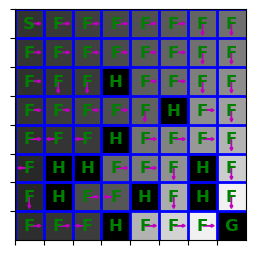

CPU times: user 10.2 s, sys: 76.8 ms, total: 10.3 s
Wall time: 25.3 s


In [25]:
%%time

from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

Массовые испытания

In [26]:
%%time

mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Отлинчая работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 
средняя награда:  1.0
Отлинчая работа!
CPU times: user 1.03 s, sys: 53.4 ms, total: 1.08 s
Wall time: 1.07 s


In [27]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.62330   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.50487   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.40894   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.34868   |   V(start): 0.349 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.06529   |   V(start): 0.410 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.05832   |   V(start): 0.468 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.01139   |   V(start): 0.480 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.00764   |   V(start): 0.487 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.00164   |   V(start): 0.489 
Итерация   11   |   разность max

In [28]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.75000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.50625   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.39867   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.26910   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.18164   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.14013   |   V(start): 0.140 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.07028   |   V(start): 0.199 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.06030   |   V(start): 0.260 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.02594   |   V(start): 0.285 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.01918   |   V(start): 0.305 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.00858   |   V(start): 0.313 
Итерация   11   |   разность max

In [29]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.80000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.57600   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.41472   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.29860   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.24186   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.19349   |   V(start): 0.000 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.15325   |   V(start): 0.000 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.12288   |   V(start): 0.000 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.09930   |   V(start): 0.000 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.08037   |   V(start): 0.000 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.06426   |   V(start): 0.000 
Итерация   11   |   разность max

# Итерационная оптимизация политики, Policy Iteration (вплоть до 4 баллов)

Требуется имплементировать явную итерационную оптимизацию политики, Policy Iteration (PI) согласно следующему псевдокоду:

---
Инициализация $\pi_0$   `// случайная или константная`

Для $n=0, 1, 2, \dots$
- Вычислить функцию $V^{\pi_{n}}$
- С помощью $V^{\pi_{n}}$, вычислить функцию $Q^{\pi_{n}}$
- Вычислить новую политику $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

В отличие от VI, Policy Iteration требует явное вычисление политики &mdash; выбранное действие для каждого состояния &mdash; и оценку $V^{\pi_{n}}$ на основе данной политики. Обновление политики происходит после (итеративного) вычисления V-функции.


Ниже представлены несколько функций-помощников, которые могут оказаться полезными при имплементации методов.

In [30]:
import numpy as np
import typing as tp
from mdp import MDP

transition_probs = {
    "s0": {"a0": {"s0": 0.5, "s2": 0.5}, "a1": {"s2": 1}},
    "s1": {"a0": {"s0": 0.7, "s1": 0.1, "s2": 0.2}, "a1": {"s1": 0.95, "s2": 0.05}},
    "s2": {"a0": {"s0": 0.4, "s1": 0.6}, "a1": {"s0": 0.3, "s1": 0.3, "s2": 0.4}},
}
rewards = {"s1": {"a0": {"s0": +5}}, "s2": {"a1": {"s0": -1}}}


mdp = MDP(transition_probs, rewards, initial_state="s0")

Настало время написать функцию под названием `compute_vpi`, которая вычисляет функцию $V^{\pi}$ для произвольной политики $\pi$.

В отличие от VI, в этот раз требуется точное решение, не просто одна итерация.

Напоминаем, что $V^{\pi}$ удовлетворяет следующему линейному соотношению:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

Вам потребуется решить систему линейных алгебраических уравнений в коде. (Найдите точное решение, например, С помощью `np.linalg.solve` или метода простых итераций.)

In [31]:
def compute_vpi(
    mdp: MDP, policy: tp.Dict[str, str], gamma: float = 0.9
) -> tp.Dict[str, float]:
    """
    Вычисляет V^pi(s) ДЛЯ ВСЕХ СОСТОЯНИЙ при текущей политике.
    :параметр policy: словарь выбранных на данный момент действий {s : a}
    :возвращает: словарь {state : V^pi(state) для всех state}
    """
    all_states = sorted(mdp.get_all_states())
    A = np.zeros(shape=(len(all_states), len(all_states)), dtype=np.float32)
    b = np.zeros(shape=(len(all_states),), dtype=np.float32)
    for i, state in enumerate(all_states):
        for j, next_state in enumerate(all_states):
            P, R = 0.0, 0.0
            if not mdp.is_terminal(state):
                P = mdp.get_transition_prob(state, policy[state], next_state)
                R = mdp.get_reward(state, policy[state], next_state)
            b[i] -= P * R
            A[i, j] = gamma * P
            if next_state == state:
                A[i, j] -= 1.0
    solution = np.linalg.solve(A, b)
    result = {}
    for i, state in enumerate(all_states):
        result[state] = solution[i]
    return result

In [32]:
%%time

test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma=0.9)

print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi должен возвращать словарь {state : V^pi(state) для всех state}"

{'s0': 8.031921, 's1': 11.171972, 's2': 8.924357}
CPU times: user 660 µs, sys: 0 ns, total: 660 µs
Wall time: 604 µs


Как только получены новые ценности состояний, время обновить текущую политику.

In [33]:
def compute_new_policy(
    mdp: MDP, vpi: tp.Dict[str, float], gamma: float = 0.9
) -> tp.Dict[str, str]:
    """
    Вычисляет жадно новую политику как argmax по функции ценности
    :параметр vpi: словарь {state : V^pi(state) для всех state}
    :возвращает: словарь {state : оптимальное действие для всех state}
    """
    all_states = mdp.get_all_states()
    return {state: get_optimal_action(mdp, vpi, state, gamma) for state in all_states}

In [34]:
%%time

new_policy = compute_new_policy(mdp, new_vpi, gamma=0.9)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy должен возвращать словарь {состояние : оптимальное действие}"

{'s0': 'a1', 's1': 'a0', 's2': 'a0'}
CPU times: user 0 ns, sys: 239 µs, total: 239 µs
Wall time: 246 µs


__Основной цикл__

In [35]:
def policy_iteration(
    mdp: MDP,
    policy: tp.Dict[str, str] = None,
    gamma: float = 0.9,
    num_iter: int = 1000,
    min_difference: float = 1e-5,
    verbose: bool = False,
) -> tp.Tuple[tp.Dict[str, float], tp.Dict[str, str]]:
    """
    Запуск итерационной оптимизации политики в цикле на num_iter итераций, или пока max_s|V_new(s) - V_old(s)|
    не станет меньше min_difference. Если начальная политика не дана, то инициализация случайная.
    """
    if policy is None:
        policy = {
            s: (
                np.random.choice(mdp.get_possible_actions(s))
                if not mdp.is_terminal(s)
                else None
            )
            for s in mdp.get_all_states()
        }
    state_values = compute_vpi(mdp, policy, gamma)
    for i in range(num_iter):
        new_policy = compute_new_policy(mdp, state_values, gamma)
        assert isinstance(new_policy, dict)
        new_state_values = compute_vpi(mdp, new_policy, gamma)

        # Вычислить темпоральную разность по значениям ценности
        diff = max(
            abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states()
        )

        if verbose:
            print(
                "Итерация %4i   |   разность max_s|V_new(s) - V_old(s)|: %6.5f   |   V(start): %.3f "
                % (i, diff, new_state_values[mdp._initial_state])
            )

        state_values = new_state_values
        policy = new_policy
        if diff < min_difference:
            break
    return state_values, policy

__Ваши результаты экспериментирования с PI__

< Сравнение PI и VI на различных MDP (FrozenLake, варьируя slip_chance), на малом и большом FrozenLake >

In [36]:
from mdp import FrozenLakeEnv

mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()
gamma = 0.9

*FFF
FHFH
FFFH
HFFG



In [37]:
%%time

mdp = FrozenLakeEnv(slip_chance=0)
state_values, policy = policy_iteration(mdp, verbose=True)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(policy.get(s))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Отлинчая работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): -0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


средняя награда:  1.0
Отлинчая работа!
CPU times: user 280 ms, sys: 41.4 ms, total: 321 ms
Wall time: 310 ms


In [38]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values, policy = policy_iteration(mdp, verbose=True)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(policy.get(s))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.94441   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.86576   |   V(start): 0.023 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.64043   |   V(start): 0.442 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.17560   |   V(start): 0.450 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.04029   |   V(start): 0.490 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.490 
средняя награда:  0.883
Отличная работа!
CPU times: user 274 ms, sys: 42.6 ms, total: 317 ms
Wall time: 292 ms


In [39]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values, policy = policy_iteration(mdp, verbose=True)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(policy.get(s))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.71400   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.59241   |   V(start): 0.325 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.325 
средняя награда:  0.663
Отличная работа!
CPU times: user 266 ms, sys: 11.2 ms, total: 278 ms
Wall time: 269 ms


In [40]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values, policy = policy_iteration(mdp, verbose=True)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(policy.get(s))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.87912   |   V(start): 0.118 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.59018   |   V(start): 0.141 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.12803   |   V(start): 0.141 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.04348   |   V(start): 0.141 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.00657   |   V(start): 0.141 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.00231   |   V(start): 0.141 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00056   |   V(start): 0.141 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.141 
средняя награда:  0.746
Отличная работа!
CPU times: user 1.22 s, sys: 24 ms, total: 1.24 s
Wall time: 1.22 s


# Поиск MDP, на котором Value Iteration работает достаточно долго (вплоть до 2 баллов)

Когда запускали Value Iteration на небольшой задаче frozen lake, последняя итерация, на которой изменялась стратегия обучаемой политики, была под номером 6 &mdash; то есть Value Iteration находил оптимальную политику на итерации 6. Существуют ли какие-либо гарантии на то, что в общем случае поиск оптимальной политики сверху ограничен конечным числом в MDP с негораниченным горизонтом с дисконтированием? Ответ без дополнительных предположений отрицательный, более того, можно предложить пример MDP, в котором жадный алгоритм оптимизации политики будет работать произвольное наперёд заданное заданное количество итераций.

Ваша задача: предъявить MDP с не более чем 3 состояниями и 2 действиями такой, что на нём алгоритм Value Iteration до останова требует, как минимум, 50 итераций. Используйте фактор дисконтирования, равный 0.95 (Однако, заметим, что величина дисконтирования тут не играет особой роли &mdash; в теории Вы можете предъявить MDP с произвольным дисконтированием, отвечающий требованиям выше.)

Замечание: V-функция ценности должна измениться хотя бы один раз после 50-ой итерации (включая 50-ую итерацию), не требуется изменение V-функции на каждой итерации.

In [41]:
transition_probs = {
    "s0": {"a0": {"s0": 0.9, "s1": 0.1}, "a1": {"s0": 0.9, "s2": 0.1}},
    "s1": {"a0": {"s1": 0.9, "s2": 0.1}, "a1": {"s1": 0.9, "s0": 0.1}},
    "s2": {"a0": {"s2": 0.9, "s0": 0.1}, "a1": {"s2": 0.9, "s1": 0.1}},
}

rewards = {
    "s0": {"a0": {"s1": 0.5}, "a1": {"s2": 0.01}},
    "s1": {"a0": {"s2": 0.5}, "a1": {"s0": 0.01}},
    "s2": {"a0": {"s0": 0.5}, "a1": {"s1": 0.01}},
}


from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))
# Не бойтесь изменять начальное состояние initial_state

In [42]:
%%time

gamma = 0.95
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(55):
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1, gamma=gamma)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    print("Количество поменявшихся действий = %i \n" % n_changes)
    policy = new_policy

# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

после итерации 0
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.05000   |   V(start): 0.050 
Количество поменявшихся действий = 0 

после итерации 1
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.04750   |   V(start): 0.098 
Количество поменявшихся действий = 0 

после итерации 2
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.04512   |   V(start): 0.143 
Количество поменявшихся действий = 0 

после итерации 3
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.04287   |   V(start): 0.185 
Количество поменявшихся действий = 0 

после итерации 4
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.04073   |   V(start): 0.226 
Количество поменявшихся действий = 0 

после итерации 5
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.03869   |   V(start): 0.265 
Количество поменявшихся действий = 0 

после итерации 6
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.03675   |   V(start): 0.302 
Количество поменявшихся действи